### Import the Required Modules

In [1]:
import os
import math
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
# from functools import partial
# from bayes_opt import BayesianOptimization

# Keras modules
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers, layers
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Dense

Using TensorFlow backend.


### Load and Pre-process the Dataset

In [2]:
print(os.listdir('../input/'))

# Load the datasets
sample_full_data = loadmat('../input/Digit_Dataset_Full.mat')
label_train_data = pd.read_csv("../input/Digit_Dataset_Full_Train_Labels.csv")
label_test_data = pd.read_csv("../input/Digit_Dataset_Full_Test_Labels.csv")

# Get data from the datasets
X_train_orig = sample_full_data['Image'][0, 0][0]
X_test_orig = sample_full_data['Image'][0, 0][1]
Y_train_orig = label_train_data.values[:, 0]
Y_test_orig = label_test_data.values[:, 0]

# Print details of the orignal data
print("X_train_orig shape: " + str(X_train_orig.shape))
print("X_test_orig shape: " + str(X_test_orig.shape))
print("Y_train_orig shape: " + str(Y_train_orig.shape))
print("Y_test_orig shape: " + str(Y_test_orig.shape), "\n")

# Reshape the input data for keras
split_fraction = 0.9     # should be greater than 0.5
train_set_len = math.ceil((X_train_orig.shape[3] + X_test_orig.shape[3]) * split_fraction)
test_set_len = X_train_orig.shape[3] + X_test_orig.shape[3] - train_set_len
X_train = np.zeros((train_set_len, X_train_orig.shape[0], X_train_orig.shape[1], X_train_orig.shape[2]))
X_test = np.zeros((test_set_len, X_train_orig.shape[0], X_train_orig.shape[1], X_train_orig.shape[2]))
Y_train = np.zeros((train_set_len, 1))
Y_test = np.zeros((test_set_len, 1))

# Split into train and test, by the given split fraction
for i in range(train_set_len + test_set_len):
    if i < train_set_len:
        if i < X_train_orig.shape[3]:
            X_train[i] = X_train_orig[:, :, :, i]
            Y_train[i] = Y_train_orig[i]
        else:
            X_train[i] = X_test_orig[:, :, :, i - X_train_orig.shape[3]]
            Y_train[i] = Y_test_orig[i - X_train_orig.shape[3]]
        
    else:
        if i < X_train_orig.shape[3]:
            X_test[i - train_set_len] = X_train_orig[:, :, :, i]
            Y_test[i - train_set_len] = Y_train_orig[i]
        else:
            X_test[i - train_set_len] = X_test_orig[:, :, :, i - X_train_orig.shape[3]]
            Y_test[i - train_set_len] = Y_test_orig[i - X_train_orig.shape[3]]

# Convert the integer labels into one-hot
Y_train = to_categorical(Y_train, num_classes=10, dtype='float32')
Y_test = to_categorical(Y_test, num_classes=10, dtype='float32')

# Print details of the reshaped data
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_train shape: " + str(Y_train.shape))
print("Y_test shape: " + str(Y_test.shape))

# Pickle the preprocessed dataset
# file_name = ["X_Digit_Train.data", "Y_Digit_Train.data", "X_Digit_Test.data", "Y_Digit_Test.data"]
# dataset = [X_train, Y_train, X_test, Y_test]
# for i, j in enumerate(file_name):
#     with open(j, 'wb') as fileObject:
#         pickle.dump(dataset[i] ,fileObject)

# Create an image generator class
imgGentrain = ImageDataGenerator()
imgGentest = ImageDataGenerator()

train_batch = imgGentrain.flow(
    x=X_train,
    y=Y_train,
    batch_size=32,
    shuffle=True,
    seed=1)
test_batch = imgGentest.flow(
    x=X_test,
    y=Y_test,
    batch_size=32,
    shuffle=True,
    seed=2)

['Digit_Dataset_Full_Train_Labels.csv', 'Digit_Dataset_Full.mat', 'Digit_Dataset_Half.mat', 'Digit_Dataset_Half_Labels.csv', 'Digit_Dataset_Full_Test_Labels.csv']
X_train_orig shape: (28, 28, 1, 9000)
X_test_orig shape: (28, 28, 1, 1000)
Y_train_orig shape: (9000,)
Y_test_orig shape: (1000,) 

X_train shape: (9000, 28, 28, 1)
X_test shape: (1000, 28, 28, 1)
Y_train shape: (9000, 10)
Y_test shape: (1000, 10)


### Example of an Image

y = [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


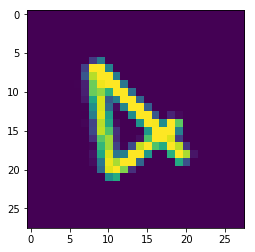

In [3]:
index = 3600    # just some random image for preview
plt.imshow(X_train[index, :, :, 0])
print("y = " + str(np.squeeze(Y_train[index, :])))

### Create a Model

In [4]:
def create_model(lr=0.001, beta_1=0.9, dropout=False):
    # Delete the previous model, if there exists any
    try: del model
    except: pass

    # Create a new model
    model = Sequential()

    # Add a convolutional layer
    model.add(Conv2D(filters=20, kernel_size=5, strides=(1, 1), padding='valid', input_shape=(28, 28, 1)))
    model.add(layers.ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Add dropout, if dropout variable is set to True
    if dropout: model.add(Dropout(rate=0.5))
    
    # Flatten the output
    model.add(Flatten())

    # Add a dense layer
    model.add(Dense(10))
    model.add(layers.Softmax())
    optAdam = optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=optAdam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Compare Dropout Effect

In [5]:
def fit_with(lr=0.001, beta_1=0.9, dropout=False):
    # Create the model using a specified hyperparameters.
    model = create_model(lr=lr, beta_1=beta_1, dropout=dropout)
    
    # Train the model with the train dataset.
    model.fit_generator(
        generator=train_batch,
        steps_per_epoch=len(train_batch),
        epochs=3)
    
    # print the test accuracy
    score = model.evaluate(X_test, Y_test, verbose = 0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    # return the test accuracy
    return score[1]

# Print the training results
dropout_list = [True, False]
for drop in dropout_list:
    print("Accuracy when", "using" if drop else "not using" ,"dropout is", fit_with(dropout=drop), "\n")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
282/282 [==============================] - 6s 20ms/step - loss: 7.9990 - acc: 0.3693
Epoch 2/3
282/282 [==============================] - 1s 5ms/step - loss: 0.9847 - acc: 0.7014
Epoch 3/3
282/282 [==============================] - 1s 5ms/step - loss: 0.4588 - acc: 0.8445
Test loss: 0.14666560244560242
Test accuracy: 0.956
Accuracy when using dropout is 0.956 

Epoch 1/3
282/282 [==============================] - 2s 6ms/step - loss: 11.8319 - acc: 0.2500
Epoch 2/3
282/282 [==============================] - 1s 5ms/step - loss: 9.7031 - acc: 0.3849
Epoch 3/3
282/282 [==============================] - 1s 5ms/step - loss: 8.7062 - acc: 0.4478
Test loss: 8.582340234692612
Test accuracy: 0.45
Accuracy when not using dropout is 0.45 

